In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from utils import load_data, EventRolling, EventRollingConfig
warnings.filterwarnings("ignore")

##### Plot figure

In [2]:
def plot_fed_funds_rate_beta(
    results_df_vnd: pd.DataFrame,
    results_df_cny: pd.DataFrame,
    tightening_periods: list,
    beta_col: str = "beta_fed_funds_t",
    sig_col: str = "significant_fed_funds_t",
    title: str = "Fed action matters more during monetary tightening"
):
    """
    Only plot markers at statistically significant points
    """

    dates = pd.to_datetime(results_df_vnd["event_date"])

    beta_vnd = results_df_vnd[beta_col]
    beta_cny = results_df_cny[beta_col]

    sig_vnd = results_df_vnd[sig_col]
    sig_cny = results_df_cny[sig_col]

    fig, ax_left = plt.subplots(figsize=(16, 7))

    for start, end in tightening_periods:
        color = "red" if start == "2022-02-01" else "gray"
        ax_left.axvspan(
            pd.to_datetime(start),
            pd.to_datetime(end),
            color=color,
            alpha=0.18,
            zorder=0
        )

    ax_left.plot(
        dates,
        beta_vnd,
        linewidth=2,
        label="β Fed action (USD/VND)",
        zorder=2
    )

    ax_left.scatter(
        dates[sig_vnd],
        beta_vnd[sig_vnd],
        s=45,
        zorder=3,
        label="USD/VND significant"
    )

    ax_left.axhline(0, linestyle="--", linewidth=1)
    ax_left.set_ylabel("β Fed funds rate (USD/VND)")
    ax_left.grid(True, alpha=0.3)

    ax_right = ax_left.twinx()

    ax_right.plot(
        dates,
        beta_cny,
        linewidth=2,
        color="tab:orange",
        label="β Fed action (USD/CNY)",
        zorder=2
    )

    ax_right.scatter(
        dates[sig_cny],
        beta_cny[sig_cny],
        s=45,
        color="tab:orange",
        zorder=3,
        label="USD/CNY significant"
    )

    ax_right.axhline(0, linestyle="--", linewidth=1, color="tab:orange")
    ax_right.set_ylabel("β Fed funds rate (USD/CNY)")

    ax_left.xaxis.set_major_locator(
        mdates.MonthLocator(bymonth=[1, 4, 7, 10])
    )

    def month_year_formatter(x, pos):
        dt = mdates.num2date(x)
        if dt.month == 1:
            return f"{dt.year}"
        elif dt.month == 4:
            return "Apr"
        elif dt.month == 7:
            return "Jul"
        elif dt.month == 10:
            return "Oct"
        return ""

    ax_left.xaxis.set_major_formatter(
        plt.FuncFormatter(month_year_formatter)
    )

    ax_left.set_xlabel("Calendar Time")
    ax_left.set_title(title)

    lines_l, labels_l = ax_left.get_legend_handles_labels()
    lines_r, labels_r = ax_right.get_legend_handles_labels()

    ax_left.legend(
        lines_l + lines_r,
        labels_l + labels_r,
        loc="upper left"
    )

    plt.tight_layout()
    plt.show()


##### Count significant events

In [3]:
def count_significant_events(
    df,
    sig_prefix="significant_",
    count_col="significant_beta_count",
    event_flag_col="is_event_significant",
    verbose=True
):
    sig_cols = [c for c in df.columns if c.startswith(sig_prefix)]

    if len(sig_cols) == 0:
        raise ValueError("No significance columns were found.")

    df[count_col] = df[sig_cols].sum(axis=1)

    df[event_flag_col] = df[count_col] > 0

    n_significant = df[event_flag_col].sum()
    n_total = len(df)
    ratio = n_significant / n_total if n_total > 0 else 0

    if verbose:
        print(
            f"There are {n_significant}/{n_total} significant events "
            f"({ratio:.2%})"
        )

    return {
        "n_significant": n_significant,
        "n_total": n_total,
        "ratio": ratio,
        "df": df
    }


##### Map significant events to their corresponding FOMC message labels.

In [4]:
def mapping_messages_to_significant_events(results_df_vnd: pd.DataFrame, df: pd.DataFrame) -> pd.DataFrame:
    vnd_stats = count_significant_events(results_df_vnd)
    significant_event_vnd = results_df_vnd[['event_date', "is_event_significant"]]
    significant_event_vnd['fomc_change'] = df['fomc_change'].copy().dropna().values
    return significant_event_vnd

### Robustness of the event study design

Robustness checks vary event window and event-date definitions (±10 / ±15 days; statement-day events; minutes-only events).

Results are stable: Fed action affects USD/VND more than USD/CNY, and communication—especially Monetary Policy Stance—matters most when the policy rate is unchanged.

In [5]:
new_df = load_data()

#### Alternative 1: +- 10 day

Shorter event window (±10 days) to test whether effects are concentrated close to the event date.

In [6]:
df_vnd_alter_1 = new_df.copy()

In [7]:
y_vars = ["Bid_FW_usd_vnd_1y"]

lagged_indep_vars = [
    "fed_funds"
]

event_vars = [
    "fomc_Labor Market Conditions",
    "fomc_Inflation and Inflation Expectations",
    "fomc_Economic Activity",
    "fomc_Financial Conditions",
    "fomc_Global Economic Developments",
    "fomc_Monetary Policy Stance",
    "fomc_Risks and Uncertainties",
    "fomc_action_dummy"
]

config = EventRollingConfig(
    lags=list(range(0, 1)), # no lag
    days_before=10,
    days_after=10,
    event_col="fomc_event"  # dummy event
)

analyzer = EventRolling(
    df=df_vnd_alter_1,
    x_lagged_vars=lagged_indep_vars,
    x_non_lagged_vars=event_vars,
    y_vars=y_vars,
    config=config
)

results_df_vnd = analyzer.rolling_event_regression_asymmetric()
summary_df_vnd = analyzer.summarize_results(results_df_vnd)
r_squared_mean = round(results_df_vnd['r_squared'].mean(), 5)
print(f'R_Squared: {r_squared_mean}')
display(summary_df_vnd)

R_Squared: 0.40506


,variable,significant_count,total_events,significant_ratio,mean_beta,mean_pval,max_abs_beta,max_beta_date
1,fomc_Inflation and Inflation Expectations,47,54,0.870,-609.963848,0.001538,6841.293525,2019-08-21
7,fomc_action_dummy,47,54,0.870,6058.014880,0.000098,16047.248151,2019-08-21
6,fomc_Risks and Uncertainties,45,54,0.833,64.666629,0.000385,2810.063987,2019-11-20
0,fomc_Labor Market Conditions,44,54,0.815,770.492678,0.000600,4814.174445,2019-08-21
2,fomc_Economic Activity,43,54,0.796,350.977585,0.001008,3209.449630,2019-08-21
5,fomc_Monetary Policy Stance,43,54,0.796,-967.322139,0.000459,8806.517909,2019-10-09
3,fomc_Financial Conditions,42,54,0.778,-151.958572,0.000647,2199.653447,2019-10-09
4,fomc_Global Economic Developments,33,54,0.611,98.024765,0.000492,1621.922345,2021-02-17
8,fed_funds_t,33,54,0.611,3482.904638,0.000482,7943.382353,2025-11-19


In [8]:
significant_event_vnd = mapping_messages_to_significant_events(results_df_vnd, new_df)
significant_event_vnd[significant_event_vnd['is_event_significant']].groupby('fomc_change').count()[['is_event_significant']]

There are 49/54 significant events (90.74%)


,is_event_significant
fomc_change,
decrease,3
increase,11
maintain,35


In [9]:
df_cny_alter_1 = new_df.copy()

In [10]:
y_vars = ["Bid_FW_usd_cny_1y"]

lagged_indep_vars = [
    "fed_funds"
]

event_vars = [
    "fomc_Labor Market Conditions",
    "fomc_Inflation and Inflation Expectations",
    "fomc_Economic Activity",
    "fomc_Financial Conditions",
    "fomc_Global Economic Developments",
    "fomc_Monetary Policy Stance",
    "fomc_Risks and Uncertainties",
    "fomc_action_dummy"
]

config = EventRollingConfig(
    lags=list(range(0, 1)), # no lag
    days_before=10,
    days_after=10,
    event_col="fomc_event"  # dummy event
)

analyzer = EventRolling(
    df=df_cny_alter_1,
    x_lagged_vars=lagged_indep_vars,
    x_non_lagged_vars=event_vars,
    y_vars=y_vars,
    config=config
)

results_df_cny = analyzer.rolling_event_regression_asymmetric()
summary_df_cny = analyzer.summarize_results(results_df_cny)
r_squared_mean = round(results_df_cny['r_squared'].mean(), 5)
print(f'R_Squared: {r_squared_mean}')
display(summary_df_cny)

R_Squared: 0.41399


,variable,significant_count,total_events,significant_ratio,mean_beta,mean_pval,max_abs_beta,max_beta_date
7,fomc_action_dummy,47,54,0.870,1.812770,0.000573,7.251161,2025-11-19
0,fomc_Labor Market Conditions,46,54,0.852,0.185683,0.000870,1.362326,2019-10-09
5,fomc_Monetary Policy Stance,46,54,0.852,-0.267456,0.000517,2.724652,2019-10-09
1,fomc_Inflation and Inflation Expectations,45,54,0.833,-0.110967,0.000441,1.734150,2019-11-20
2,fomc_Economic Activity,43,54,0.796,0.088985,0.001221,0.908217,2019-10-09
6,fomc_Risks and Uncertainties,43,54,0.796,0.010837,0.000604,0.867075,2019-11-20
3,fomc_Financial Conditions,42,54,0.778,-0.072461,0.000406,0.751255,2020-10-07
4,fomc_Global Economic Developments,33,54,0.611,-0.000946,0.002211,0.474625,2021-02-17
8,fed_funds_t,33,54,0.611,1.070359,0.000821,3.878333,2020-01-03


In [11]:
significant_event_cny = mapping_messages_to_significant_events(results_df_cny, new_df)
significant_event_cny[significant_event_cny['is_event_significant']].groupby('fomc_change').count()[['is_event_significant']]

There are 49/54 significant events (90.74%)


,is_event_significant
fomc_change,
decrease,2
increase,10
maintain,37


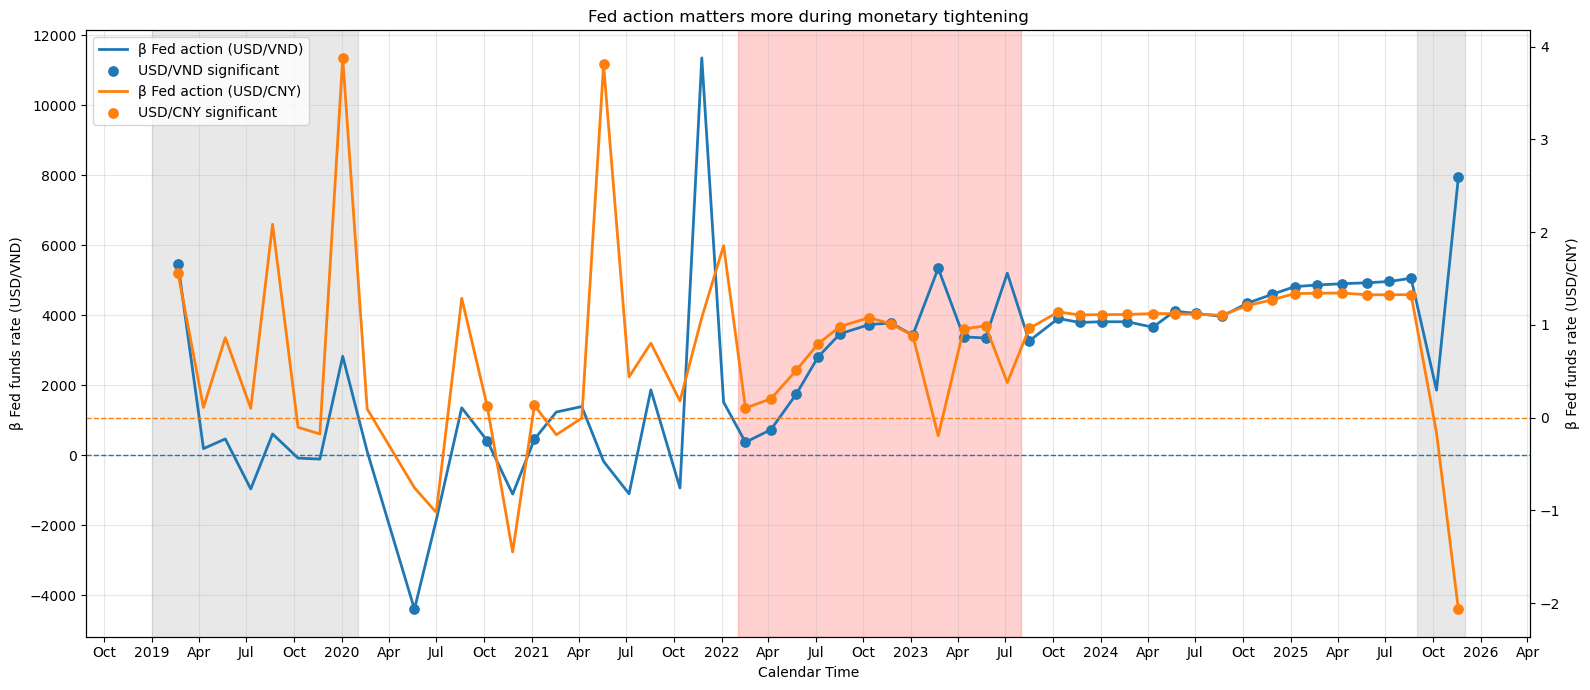

In [12]:
tightening_periods = [
    ("2019-01-01", "2020-02-01"),
    ("2022-02-01", "2023-08-01"),
    ("2025-09-01", "2025-12-01"),
]

plot_fed_funds_rate_beta(
    results_df_vnd=results_df_vnd,
    results_df_cny=results_df_cny,
    tightening_periods=tightening_periods
)

#### Alternative 2: +- 15 days

Moderately shorter window (±15 days) to check whether results are robust to a less generous event window.

In [13]:
df_vnd_alter_2 = new_df.copy()

In [14]:
y_vars = ["Bid_FW_usd_vnd_1y"]

lagged_indep_vars = [
    "fed_funds"
]

event_vars = [
    "fomc_Labor Market Conditions",
    "fomc_Inflation and Inflation Expectations",
    "fomc_Economic Activity",
    "fomc_Financial Conditions",
    "fomc_Global Economic Developments",
    "fomc_Monetary Policy Stance",
    "fomc_Risks and Uncertainties",
    "fomc_action_dummy"
]

config = EventRollingConfig(
    lags=list(range(0, 1)), # no lag
    days_before=17,
    days_after=17,
    event_col="fomc_event"  # dummy event
)

analyzer = EventRolling(
    df=df_vnd_alter_2,
    x_lagged_vars=lagged_indep_vars,
    x_non_lagged_vars=event_vars,
    y_vars=y_vars,
    config=config
)

results_df_vnd = analyzer.rolling_event_regression_asymmetric()
summary_df_vnd = analyzer.summarize_results(results_df_vnd)
r_squared_mean = round(results_df_vnd['r_squared'].mean(), 5)
print(f'R_Squared: {r_squared_mean}')
display(summary_df_vnd)

R_Squared: 0.48436


,variable,significant_count,total_events,significant_ratio,mean_beta,mean_pval,max_abs_beta,max_beta_date
0,fomc_Labor Market Conditions,52,54,0.963,1903.204858,1.204572e-03,19837.022937,2019-07-10
1,fomc_Inflation and Inflation Expectations,52,54,0.963,-720.015249,3.181281e-04,26449.363916,2019-07-10
5,fomc_Monetary Policy Stance,51,54,0.944,-1035.582246,8.407233e-04,20654.452046,2019-11-20
6,fomc_Risks and Uncertainties,51,54,0.944,735.646269,3.296438e-04,12184.070889,2023-07-05
3,fomc_Financial Conditions,49,54,0.907,-303.801949,1.446362e-03,11961.549688,2019-07-10
2,fomc_Economic Activity,48,54,0.889,1086.630323,1.671943e-04,13224.681958,2019-07-10
7,fomc_action_dummy,47,54,0.870,7420.841871,6.018166e-08,14538.731806,2019-10-09
4,fomc_Global Economic Developments,38,54,0.704,-95.220683,1.660134e-03,5349.208709,2019-07-10
8,fed_funds_t,30,54,0.556,1943.808979,7.956334e-04,5462.736434,2019-02-20


In [15]:
significant_event_vnd = mapping_messages_to_significant_events(results_df_vnd, new_df)
significant_event_vnd[significant_event_vnd['is_event_significant']].groupby('fomc_change').count()[['is_event_significant']]

There are 53/54 significant events (98.15%)


,is_event_significant
fomc_change,
decrease,3
increase,10
maintain,40


In [16]:
df_cny_alter_2 = new_df.copy()

In [17]:
y_vars = ["Bid_FW_usd_cny_1y"]

lagged_indep_vars = [
    "fed_funds"
]

event_vars = [
    "fomc_Labor Market Conditions",
    "fomc_Inflation and Inflation Expectations",
    "fomc_Economic Activity",
    "fomc_Financial Conditions",
    "fomc_Global Economic Developments",
    "fomc_Monetary Policy Stance",
    "fomc_Risks and Uncertainties",
    "fomc_action_dummy"
]

config = EventRollingConfig(
    lags=list(range(0, 1)), # no lag
    days_before=17,
    days_after=17,
    event_col="fomc_event"  # dummy event
)

analyzer = EventRolling(
    df=df_cny_alter_2,
    x_lagged_vars=lagged_indep_vars,
    x_non_lagged_vars=event_vars,
    y_vars=y_vars,
    config=config
)

results_df_cny = analyzer.rolling_event_regression_asymmetric()
summary_df_cny = analyzer.summarize_results(results_df_cny)
r_squared_mean = round(results_df_cny['r_squared'].mean(), 5)
print(f'R_Squared: {r_squared_mean}')
display(summary_df_cny)

R_Squared: 0.45695


,variable,significant_count,total_events,significant_ratio,mean_beta,mean_pval,max_abs_beta,max_beta_date
0,fomc_Labor Market Conditions,50,54,0.926,0.618003,0.001412,6.383790,2019-08-21
1,fomc_Inflation and Inflation Expectations,50,54,0.926,-0.223416,0.001444,9.013422,2019-08-21
5,fomc_Monetary Policy Stance,50,54,0.926,-0.309977,0.000813,5.936713,2019-11-20
2,fomc_Economic Activity,49,54,0.907,0.344358,0.000838,4.255860,2019-08-21
6,fomc_Risks and Uncertainties,49,54,0.907,0.267160,0.001357,3.386005,2023-07-05
7,fomc_action_dummy,47,54,0.870,2.074178,0.000038,5.124183,2019-05-22
3,fomc_Financial Conditions,44,54,0.815,-0.157323,0.000684,3.734852,2019-07-10
4,fomc_Global Economic Developments,37,54,0.685,-0.042231,0.001418,1.691676,2019-07-10
8,fed_funds_t,29,54,0.537,0.664991,0.001423,2.450617,2020-01-03


In [18]:
significant_event_cny = mapping_messages_to_significant_events(results_df_cny, new_df)
significant_event_cny[significant_event_cny['is_event_significant']].groupby('fomc_change').count()[['is_event_significant']]

There are 53/54 significant events (98.15%)


,is_event_significant
fomc_change,
decrease,3
increase,10
maintain,40


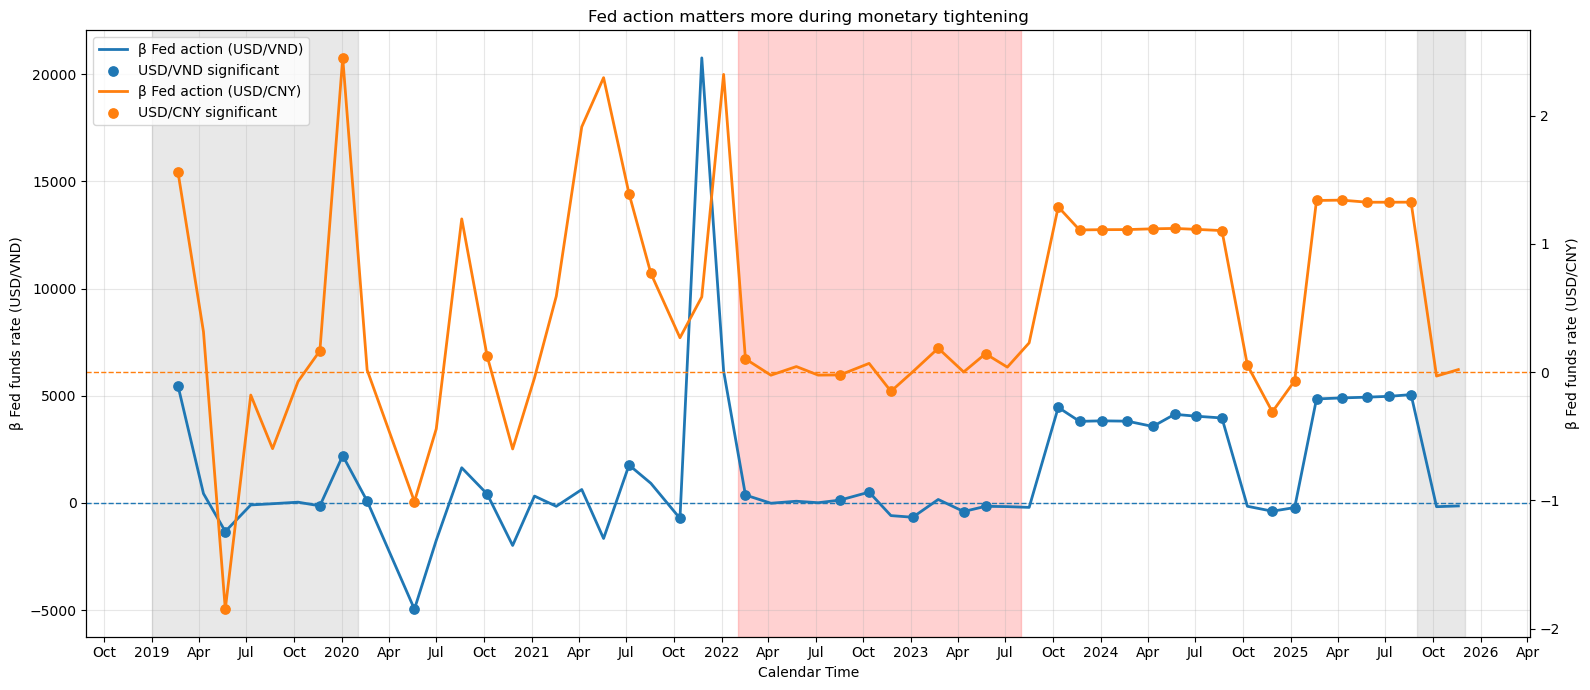

In [19]:
tightening_periods = [
    ("2019-01-01", "2020-02-01"),
    ("2022-02-01", "2023-08-01"),
    ("2025-09-01", "2025-12-01"),
]

plot_fed_funds_rate_beta(
    results_df_vnd=results_df_vnd,
    results_df_cny=results_df_cny,
    tightening_periods=tightening_periods
)

#### Alternative 3: Statement-day events

Restrict to statement-day events to isolate immediate communication effects tied to official statements.

In [20]:
new_df['fomc_event_statement'] = new_df['fomc_Labor Market Conditions'].notna().astype(int)

In [21]:
df_vnd_alter_3 = new_df.copy()

In [22]:
y_vars = ["Bid_FW_usd_vnd_1y"]

lagged_indep_vars = [
    "fed_funds"
]

event_vars = [
    "fomc_Labor Market Conditions",
    "fomc_Inflation and Inflation Expectations",
    "fomc_Economic Activity",
    "fomc_Financial Conditions",
    "fomc_Global Economic Developments",
    "fomc_Monetary Policy Stance",
    "fomc_Risks and Uncertainties",
    "fomc_action_dummy"
]

config = EventRollingConfig(
    lags=list(range(0, 1)), # no lag
    days_before=21,
    days_after=21,
    event_col="fomc_event_statement"  # dummy statement event
)

analyzer = EventRolling(
    df=df_vnd_alter_3,
    x_lagged_vars=lagged_indep_vars,
    x_non_lagged_vars=event_vars,
    y_vars=y_vars,
    config=config
)

results_df_vnd = analyzer.rolling_event_regression_asymmetric()
summary_df_vnd = analyzer.summarize_results(results_df_vnd)
r_squared_mean = round(results_df_vnd['r_squared'].mean(), 5)
print(f'R_Squared: {r_squared_mean}')
display(summary_df_vnd)

R_Squared: 0.52237


,variable,significant_count,total_events,significant_ratio,mean_beta,mean_pval,max_abs_beta,max_beta_date
0,fomc_Labor Market Conditions,51,54,0.944,2908.572580,0.000456,27894.766090,2020-01-03
1,fomc_Inflation and Inflation Expectations,51,54,0.944,-600.705494,0.000023,26832.919377,2019-07-10
5,fomc_Monetary Policy Stance,50,54,0.926,-947.376870,0.000008,20632.297277,2019-11-20
6,fomc_Risks and Uncertainties,50,54,0.926,1015.752831,0.000073,11943.676103,2023-07-05
2,fomc_Economic Activity,48,54,0.889,1659.308401,0.000019,22599.724408,2020-01-03
3,fomc_Financial Conditions,48,54,0.889,54.314077,0.001091,12122.411914,2019-07-10
7,fomc_action_dummy,47,54,0.870,7160.647777,0.001129,14564.350919,2019-10-09
4,fomc_Global Economic Developments,36,54,0.667,150.819133,0.000054,9298.255363,2020-01-03
8,fed_funds_t,31,54,0.574,1142.848486,0.002264,4977.672762,2025-07-09


In [23]:
significant_event_vnd = mapping_messages_to_significant_events(results_df_vnd, new_df)
significant_event_vnd[significant_event_vnd['is_event_significant']].groupby('fomc_change').count()[['is_event_significant']]

There are 51/54 significant events (94.44%)


,is_event_significant
fomc_change,
decrease,3
increase,11
maintain,37


In [24]:
df_cny_alter_3 = new_df.copy()

In [25]:
y_vars = ["Bid_FW_usd_cny_1y"]

lagged_indep_vars = [
    "fed_funds"
]

event_vars = [
    "fomc_Labor Market Conditions",
    "fomc_Inflation and Inflation Expectations",
    "fomc_Economic Activity",
    "fomc_Financial Conditions",
    "fomc_Global Economic Developments",
    "fomc_Monetary Policy Stance",
    "fomc_Risks and Uncertainties",
    "fomc_action_dummy"
]

config = EventRollingConfig(
    lags=list(range(0, 1)), # no lag
    days_before=21,
    days_after=21,
    event_col="fomc_event_statement"  # dummy statement event
)

analyzer = EventRolling(
    df=df_cny_alter_3,
    x_lagged_vars=lagged_indep_vars,
    x_non_lagged_vars=event_vars,
    y_vars=y_vars,
    config=config
)

results_df_cny = analyzer.rolling_event_regression_asymmetric()
summary_df_cny = analyzer.summarize_results(results_df_cny)
r_squared_mean = round(results_df_cny['r_squared'].mean(), 5)
print(f'R_Squared: {r_squared_mean}')
display(summary_df_cny)

R_Squared: 0.47696


,variable,significant_count,total_events,significant_ratio,mean_beta,mean_pval,max_abs_beta,max_beta_date
0,fomc_Labor Market Conditions,49,54,0.907,0.842743,9.429569e-06,6.850188,2019-07-10
5,fomc_Monetary Policy Stance,49,54,0.907,-0.343727,1.086958e-03,5.937686,2019-11-20
1,fomc_Inflation and Inflation Expectations,48,54,0.889,-0.275465,4.039844e-07,9.133585,2019-07-10
2,fomc_Economic Activity,48,54,0.889,0.465734,1.164666e-06,5.532140,2020-01-03
6,fomc_Risks and Uncertainties,47,54,0.870,0.321106,1.806727e-04,3.208248,2023-07-05
7,fomc_action_dummy,46,54,0.852,2.109332,5.345585e-06,5.170886,2019-05-22
3,fomc_Financial Conditions,44,54,0.815,-0.065850,1.439787e-04,4.166679,2019-07-10
4,fomc_Global Economic Developments,36,54,0.667,0.015905,4.824290e-04,2.282846,2020-01-03
8,fed_funds_t,26,54,0.481,0.653291,3.337185e-03,2.906688,2021-04-07


In [26]:
significant_event_cny = mapping_messages_to_significant_events(results_df_cny, new_df)
significant_event_cny[significant_event_cny['is_event_significant']].groupby('fomc_change').count()[['is_event_significant']]

There are 51/54 significant events (94.44%)


,is_event_significant
fomc_change,
decrease,3
increase,11
maintain,37


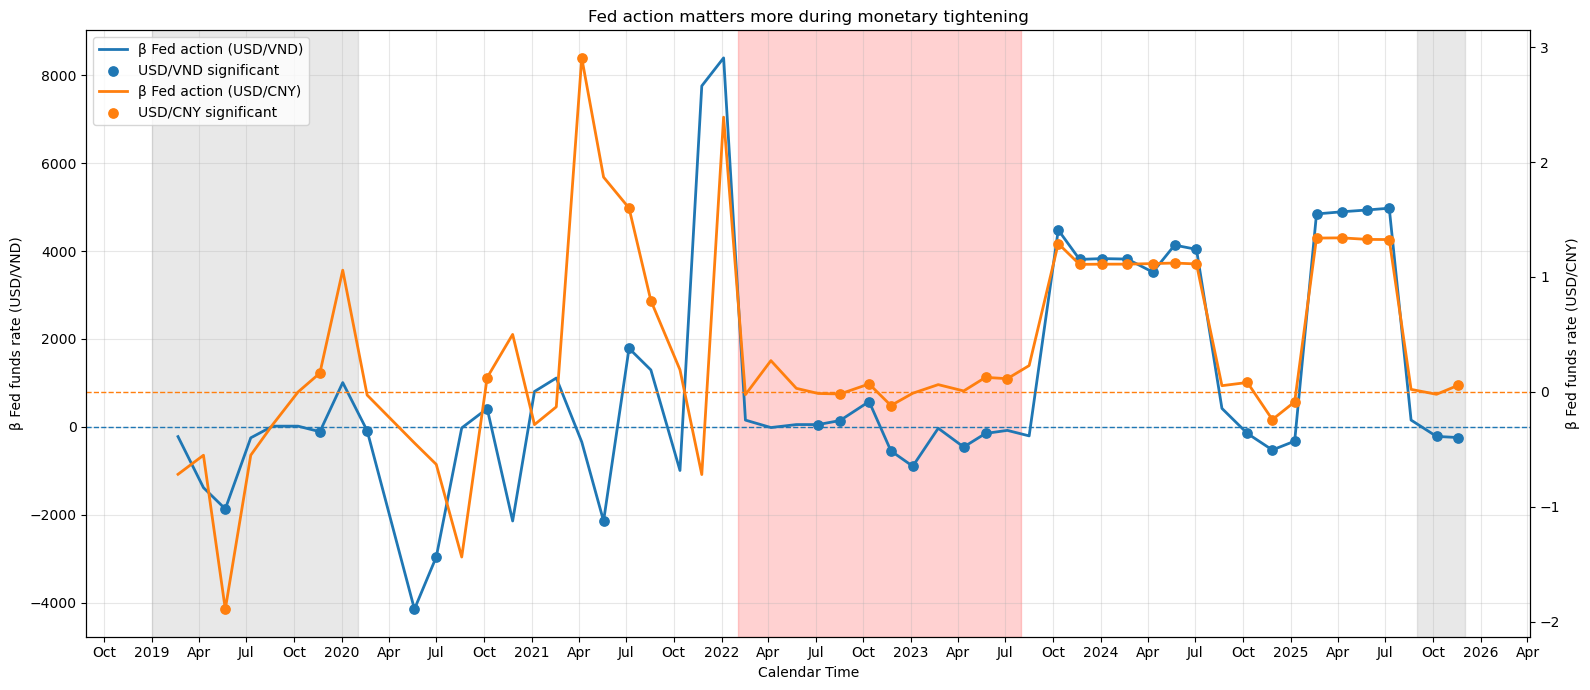

In [27]:
tightening_periods = [
    ("2019-01-01", "2020-02-01"),
    ("2022-02-01", "2023-08-01"),
    ("2025-09-01", "2025-12-01"),
]

plot_fed_funds_rate_beta(
    results_df_vnd=results_df_vnd,
    results_df_cny=results_df_cny,
    tightening_periods=tightening_periods
)

#### Alternative 4: Minutes-only events

Run regressions on minutes-only events and exclude FOMC statement message variables to isolate communication effects absent statement messages.

In [28]:
df_vnd_alter_4 = new_df.copy()

In [29]:
y_vars = ["Bid_FW_usd_vnd_1y"]

lagged_indep_vars = [
    "fed_funds"
]

event_vars = [
    "fomc_Labor Market Conditions",
    "fomc_Inflation and Inflation Expectations",
    "fomc_Economic Activity",
    "fomc_Financial Conditions",
    "fomc_Global Economic Developments",
    "fomc_Monetary Policy Stance",
    "fomc_Risks and Uncertainties"
]

config = EventRollingConfig(
    lags=list(range(0, 1)),
    days_before=21,
    days_after=21,
    event_col="fomc_event" 
)

analyzer = EventRolling(
    df=df_vnd_alter_4,
    x_lagged_vars=lagged_indep_vars,
    x_non_lagged_vars=event_vars,
    y_vars=y_vars,
    config=config
)

results_df_vnd = analyzer.rolling_event_regression_asymmetric()
summary_df_vnd = analyzer.summarize_results(results_df_vnd)
r_squared_mean = round(results_df_vnd['r_squared'].mean(), 5)
print(f'R_Squared: {r_squared_mean}')
display(summary_df_vnd)

R_Squared: 0.51069


,variable,significant_count,total_events,significant_ratio,mean_beta,mean_pval,max_abs_beta,max_beta_date
0,fomc_Labor Market Conditions,51,54,0.944,9503.697364,2.144405e-04,50458.110840,2025-11-19
1,fomc_Inflation and Inflation Expectations,51,54,0.944,-344.566494,1.346296e-06,43982.689899,2025-11-19
2,fomc_Economic Activity,51,54,0.944,4829.026363,2.202686e-05,61123.794716,2025-10-08
6,fomc_Risks and Uncertainties,51,54,0.944,-25.381898,2.147278e-04,59980.920430,2025-10-08
5,fomc_Monetary Policy Stance,50,54,0.926,-4137.580376,5.571147e-05,42987.269953,2025-01-08
3,fomc_Financial Conditions,48,54,0.889,-690.217621,4.589109e-07,53721.419186,2025-10-08
4,fomc_Global Economic Developments,38,54,0.704,-1098.214351,4.840075e-04,26952.125093,2024-11-26
7,fed_funds_t,33,54,0.611,1333.821882,2.801326e-03,6034.848338,2025-07-09


In [30]:
significant_event_vnd = mapping_messages_to_significant_events(results_df_vnd, new_df)
significant_event_vnd[significant_event_vnd['is_event_significant']].groupby('fomc_change').count()[['is_event_significant']]

There are 52/54 significant events (96.30%)


,is_event_significant
fomc_change,
decrease,3
increase,11
maintain,38


In [31]:
df_cny_alter_4 = new_df.copy()

In [32]:
y_vars = ["Bid_FW_usd_cny_1y"]

lagged_indep_vars = [
    "fed_funds"
]

event_vars = [
    "fomc_Labor Market Conditions",
    "fomc_Inflation and Inflation Expectations",
    "fomc_Economic Activity",
    "fomc_Financial Conditions",
    "fomc_Global Economic Developments",
    "fomc_Monetary Policy Stance",
    "fomc_Risks and Uncertainties",
]

config = EventRollingConfig(
    lags=list(range(0, 1)),
    days_before=21,
    days_after=21,
    event_col="fomc_event"  # dummy event
)

analyzer = EventRolling(
    df=df_cny_alter_4,
    x_lagged_vars=lagged_indep_vars,
    x_non_lagged_vars=event_vars,
    y_vars=y_vars,
    config=config
)

results_df_cny = analyzer.rolling_event_regression_asymmetric()
summary_df_cny = analyzer.summarize_results(results_df_cny)
r_squared_mean = round(results_df_cny['r_squared'].mean(), 5)
print(f'R_Squared: {r_squared_mean}')
display(summary_df_cny)

R_Squared: 0.46311


,variable,significant_count,total_events,significant_ratio,mean_beta,mean_pval,max_abs_beta,max_beta_date
0,fomc_Labor Market Conditions,50,54,0.926,2.747590,1.192752e-08,12.077775,2025-11-19
5,fomc_Monetary Policy Stance,50,54,0.926,-1.388728,1.251136e-04,11.916563,2025-01-08
6,fomc_Risks and Uncertainties,50,54,0.926,0.064188,2.593027e-06,15.330214,2025-10-08
1,fomc_Inflation and Inflation Expectations,49,54,0.907,-0.334709,1.082298e-08,11.013822,2025-01-08
2,fomc_Economic Activity,49,54,0.907,1.349730,2.143361e-07,15.635366,2025-10-08
3,fomc_Financial Conditions,45,54,0.833,-0.340910,5.022826e-08,13.744519,2025-10-08
4,fomc_Global Economic Developments,38,54,0.704,-0.290317,4.756935e-04,7.863054,2024-11-26
7,fed_funds_t,27,54,0.500,0.681000,1.900157e-03,2.906688,2021-04-07


In [33]:
significant_event_cny = mapping_messages_to_significant_events(results_df_cny, new_df)
significant_event_cny[significant_event_cny['is_event_significant']].groupby('fomc_change').count()[['is_event_significant']]

There are 52/54 significant events (96.30%)


,is_event_significant
fomc_change,
decrease,3
increase,11
maintain,38


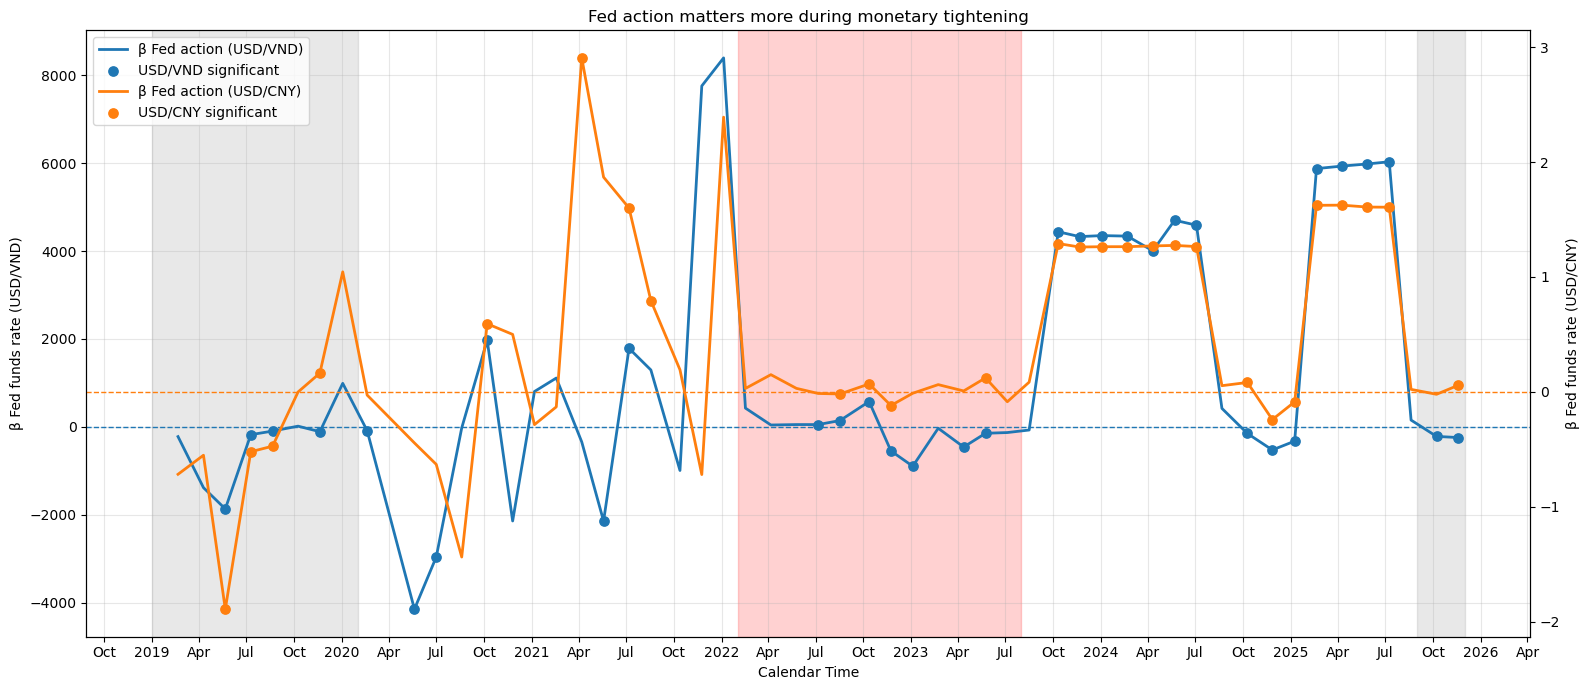

In [34]:
tightening_periods = [
    ("2019-01-01", "2020-02-01"),
    ("2022-02-01", "2023-08-01"),
    ("2025-09-01", "2025-12-01"),
]

plot_fed_funds_rate_beta(
    results_df_vnd=results_df_vnd,
    results_df_cny=results_df_cny,
    tightening_periods=tightening_periods
)